# Sparse vectors example

We're using [goodbooks-10k](https://www.kaggle.com/zygmunt/goodbooks-10k) dataset for understanding how to work with sparse vectors in Vektonn.

## Install necessary dependencies

In [1]:
! pip install --upgrade matplotlib pandas seaborn vektonn

from IPython.display import clear_output
clear_output()

In [2]:
! pip list | grep vektonn

vektonn                0.5.4               


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Get dataset and make tiny EDA

Dataset - https://www.kaggle.com/zygmunt/goodbooks-10k

First we need to download it and put into `.data` directory. One can use `download-dataset.sh` script located in the current directory.

Then we can read it:

In [4]:
books_meta = pd.read_csv('.data/books.csv').fillna('')
print(books_meta.shape)
display(books_meta.head())

(10000, 23)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9780439023480.0,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9780439554930.0,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9780316015840.0,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9780061120080.0,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9780743273560.0,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
ratings = pd.read_csv('.data/ratings.csv')
print(ratings.shape)
display(ratings.head())

(981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [6]:
ratings['book_id'].nunique(), ratings['user_id'].nunique()

(10000, 53424)

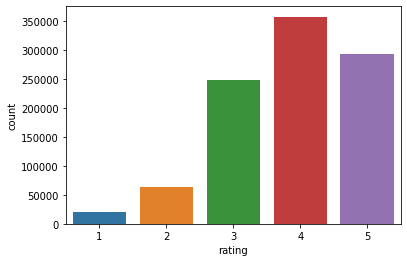

In [7]:
sns.countplot(x='rating', data=ratings);

In [8]:
avg_user_n_ratings = ratings.groupby('user_id')['book_id'].agg('count').median()
avg_book_n_ratings = ratings.groupby('book_id')['user_id'].agg('count').median()

print('Average number of user ratings: ', avg_user_n_ratings)
print('Average number of book ratings: ', avg_book_n_ratings)

Average number of user ratings:  8.0
Average number of book ratings:  100.0


## Data preparation

In [9]:
# Make a pivot table for user and books.
pivot = ratings.pivot_table(index=['user_id'], columns=['book_id'], values='rating')
print(pivot.shape)
display(pivot.head(3))

(53424, 10000)


book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Ratings have to be normalized because different books have different average ratings.
pivot_normalized = pivot.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)), axis=1)

In [11]:
# It will be better to remove users who didn't rate books because they don't affect on recommendations.
pivot_normalized.fillna(0, inplace=True)
pivot_normalized = pivot_normalized.T
pivot_normalized = pivot_normalized.loc[:, (pivot_normalized != 0).any(axis=0)]

print(pivot_normalized.shape)

(10000, 47018)


In [12]:
# Take only 11k user ratings in reason of speeding up.
pivot_normalized = pivot_normalized.iloc[:, :11000]
print(pivot_normalized.shape)

(10000, 11000)


In [13]:
# Replace zeros to nan for correct saving of sparse vectors.
pivot_normalized = pivot_normalized.replace(0, np.nan)
pivot_normalized = pivot_normalized.astype('float16')
display(pivot_normalized.head(3))

user_id,1,2,4,5,6,7,8,9,10,11,...,12074,12075,12076,12077,12078,12079,12080,12082,12083,12085
book_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Take 10 rows for testing.
test_vectors_df = pivot_normalized.sample(10, random_state=0)
display(test_vectors_df)

user_id,1,2,4,5,6,7,8,9,10,11,...,12074,12075,12076,12077,12078,12079,12080,12082,12083,12085
book_id,,,,,,,,,,,,,,,,,,,,,
9395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083313,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Other rows will be used to create a search space.
vectors_df = pivot_normalized[~pivot_normalized.index.isin(test_vectors_df.index)]
print(vectors_df.shape)

(9990, 11000)


In [16]:
# Prepare book attributes to store in Vektonn
meta_df = books_meta[['id', 'authors', 'original_title']]

test_info = meta_df[meta_df.id.isin(test_vectors_df.index)]
display(test_info)

,id,authors,original_title
898,899,"Edith Wharton, Maureen Howard",The Age of Innocence
2343,2344,Charles Bukowski,Factotum
2398,2399,Terry Goodkind,"Naked Empire (Sword of Truth, #8)"
2670,2671,Maeve Binchy,Circle of Friends
3497,3498,Melina Marchetta,On the Jellicoe Road
5506,5507,Dean Koontz,By the Light of the Moon
5906,5907,Charles Dickens,Our Mutual Friend
6451,6452,"Tachibana Higuchi, 樋口 橘",学園アリス１
8225,8226,"Thomas Hardy, Patricia Ingham",The Woodlanders
9394,9395,Louis Sachar,Small Steps


In [17]:
meta_df = meta_df[~meta_df.id.isin(test_vectors_df.index)]
print(meta_df.shape)

(9990, 3)


## Use Vektonn

### Setup data source and index schema

Define Vektonn data source:

In [18]:
%%bash

data_source_schema_dir=../../docker/config/data-sources/Examples.Books
mkdir -p $data_source_schema_dir

cat <<EOF > "$data_source_schema_dir/1.0.yaml"
vectorDimension: 11000
vectorsAreSparse: true
attributeValueTypes:
  id: Int64
  authors: String
  original_title: String
permanentAttributes: ["id"]
EOF

Define Vektonn index:

In [19]:
%%bash

index_schema_dir=../../docker/config/indices/Examples.Books
mkdir -p $index_schema_dir

cat <<EOF > "$index_schema_dir/1.0.yaml"
dataSourceId:
  name: Examples.Books
  version: 1.0
indexAlgorithm: SparnnIndex.Cosine
idAttributes: ["id"]
shardsById:
  SingleShard: {}
EOF

cat <<EOF > "../../docker/config/index-shards-topology.yaml"
Examples.Books:
  1.0:
    SingleShard: vektonn-index-shard:8082
EOF

### Start Vektonn services

In [20]:
! ../../docker/run-vektonn.sh Examples.Books
clear_output()

Init Vektonn API client:

In [21]:
from vektonn import Vektonn

vektonn_client = Vektonn('http://localhost:8081')

### Upload data points

Upload vectors and corresponding attributes to Vektonn:

In [22]:
from vektonn.dtos import VectorDto

def to_vector_dto(vectors_df_row):
    indexes, values = [], []

    # Find all non-empty values in a row for vector
    for index, value in enumerate(vectors_df_row):
        if not np.isnan(value):
            indexes.append(index)
            values.append(value)

    return VectorDto(is_sparse=True, coordinates=values, coordinate_indices=indexes)

In [23]:
from vektonn.dtos import InputDataPointDto, AttributeDto, AttributeValueDto

input_data_points = []
for idx, row in meta_df.iterrows():
    vector_dto = to_vector_dto(vectors_df.loc[row.id])
    if not vector_dto.coordinates:
        continue
    input_data_points.append(InputDataPointDto(
        attributes=[
            AttributeDto(key='id', value=AttributeValueDto(int64=row.id)),
            AttributeDto(key='authors', value=AttributeValueDto(string=row.authors)),
            AttributeDto(key='original_title', value=AttributeValueDto(string=row.original_title)),
        ],
        vector=vector_dto,
    ))
    
print(len(input_data_points))
display(input_data_points[0])

9959


InputDataPointDto(attributes=[AttributeDto(key='id', value=AttributeValueDto(string=None, guid=None, bool=None, int64=1, float64=None, date_time=None)), AttributeDto(key='authors', value=AttributeValueDto(string='Suzanne Collins', guid=None, bool=None, int64=None, float64=None, date_time=None)), AttributeDto(key='original_title', value=AttributeValueDto(string='The Hunger Games', guid=None, bool=None, int64=None, float64=None, date_time=None))], vector=VectorDto(is_sparse=True, coordinates=[0.353515625, -0.06787109375, 0.345458984375, 0.0574951171875, 0.1754150390625, 0.2332763671875, 0.1839599609375, 0.23681640625, -0.032440185546875, 0.208740234375, 0.26513671875, -0.381103515625, 0.32568359375, 0.356689453125, -0.125, -0.50244140625, 0.2353515625, 0.28173828125, -0.0168609619140625, 0.06524658203125, 0.1915283203125, 0.2352294921875, 0.139404296875, 0.07891845703125], coordinate_indices=[282, 403, 541, 1070, 1085, 1917, 2286, 2668, 3365, 3605, 4941, 5013, 5395, 6066, 6919, 8458, 926

In [24]:
data_source_name = 'Examples.Books'
data_source_version = '1.0'

try:
    vektonn_client.upload(data_source_name, data_source_version, input_data_points)
    print(f'Successfully uploaded {len(input_data_points)} data points')
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

Successfully uploaded 9959 data points


In [25]:
# wait a bit for Vektonn data indexing
import time
time.sleep(5)

### Search for similiar books

In [26]:
from vektonn.dtos import SearchQueryDto, VectorDto

index_name = 'Examples.Books'
index_version = '1.0'

query_vectors = []
for row in test_vectors_df.iterrows():
    query_vectors.append(to_vector_dto(row[1]))
    
search_query = SearchQueryDto(k=3, query_vectors=query_vectors)

try:
    search_results = vektonn_client.search(index_name, index_version, search_query)
    display(search_results[0].nearest_data_points[0].attributes)
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

[AttributeDto(key='id', value=AttributeValueDto(string=None, guid=None, bool=None, int64=5405, float64=None, date_time=None)),
 AttributeDto(key='authors', value=AttributeValueDto(string='Rick Riordan, John Rocco', guid=None, bool=None, int64=None, float64=None, date_time=None)),
 AttributeDto(key='original_title', value=AttributeValueDto(string="Percy Jackson's Greek Gods", guid=None, bool=None, int64=None, float64=None, date_time=None))]

In [27]:
# Print info about similar books.
for idx, info in enumerate(test_info.iterrows()):
    id, authors, original_title = info[1]
    print(f'For book \'{original_title}\' written by {authors} with id = {id} the most similar books by user reviews are:')
    
    for fdp in search_results[idx].nearest_data_points:
        attrs = {x.key : x.value for x in fdp.attributes}
        dist, book_id, title, authors = fdp.distance, attrs['id'].int64, attrs['original_title'].string, attrs['authors'].string
        print(f' - With cosine distance = {dist} book \'{title}\' written by {authors} with id = {book_id}.')
        
    print('-' * 30)

For book 'The Age of Innocence' written by Edith Wharton, Maureen Howard with id = 899 the most similar books by user reviews are:
 - With cosine distance = 0.7226227556744995 book 'Percy Jackson's Greek Gods' written by Rick Riordan, John Rocco with id = 5405.
 - With cosine distance = 0.8803208410743859 book 'The Ear, the Eye, and the Arm' written by Nancy Farmer with id = 8951.
 - With cosine distance = 0.8854111273393099 book '' written by Timothy J. Keller, Kathy  Keller with id = 7404.
------------------------------
For book 'Factotum' written by Charles Bukowski with id = 2344 the most similar books by user reviews are:
 - With cosine distance = 0.7739939999826176 book 'Middlemarch' written by George Eliot, Michel Faber with id = 961.
 - With cosine distance = 0.7740159242676635 book 'The Secret History' written by Donna Tartt with id = 494.
 - With cosine distance = 0.78148522395818 book 'The Once and Future King' written by T.H. White with id = 1367.
--------------------------

Note that not all "similar" books are really similar. The main reason is reducing the number of users in initial dataset to 11k.